In [14]:
import jaxdf
import jax
import jax.random as random
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
import optax
import functools as ft
import numpy as np

In [15]:
# key sequence for convenience

def _rns(key):
    while True:
        key, k = jax.random.split(key)
        yield k

rns = _rns(jax.random.PRNGKey(42))

In [16]:
m2 = -4
lam = 4
L = 2
event_shape = (L,L,1)
theory = jaxdf.lattice.scalartheory.Phi4Theory(shape = event_shape, m2 = m2, lam = lam)

In [17]:
import flax.linen as nn

class VectorField(nn.Module):
    @nn.compact
    def __call__(self, t, x):
        x_shape = x.shape
        n_hidden = 200
        act = nn.silu
        t = jnp.array(t).reshape(-1,1)
        n_features = 30
        t = jnp.concatenate([t - 0.5, *[jnp.cos(i*jnp.pi*t) for i in range(n_features)], *[jnp.sin(i*jnp.pi*t) for i in range(n_features)]],axis=-1)
        t = jnp.repeat(t,L*L, 1)
        x = x.reshape(-1, L*L)
        t = jnp.repeat(t, x.shape[0], 0)
        x = jnp.concatenate([x, *[jnp.cos(i*jnp.pi*x) for i in range(n_features)], *[jnp.sin(i*jnp.pi*x) for i in range(n_features)]],axis=-1)
        x = jnp.concatenate([x, t],axis=-1)
        x = nn.Dense(n_hidden)(x)
        x = act(x)
        x = nn.Dense(n_hidden)(x)
        x = act(x)
        x = nn.Dense(n_hidden)(x)
        x = act(x)
        x = nn.Dense(L*L)(x)
        return x.reshape(x_shape)

class GVF(nn.Module):
    vector_field: nn.Module
    @nn.compact
    def __call__(self, t, x):
        out = self.vector_field(t, x[0])
        event_shape = out.shape
        def vf(x):
            return self.vector_field(t, x.reshape(event_shape)).flatten()
        div = lambda x: jnp.trace(jax.jacfwd(vf)(x.flatten()))
        if x[0].shape[0] > 6:
            div = jax.vmap(div)
            event_shape = event_shape[1:]
        d = jnp.array(div(x[0]))
        return out, - d

In [18]:

#vector_field = jaxdf.lattice.Phi4CNF(kernel_shape = event_shape[:-1])
vector_field = GVF(VectorField())
noise_model = jaxdf.VariancePreservingModel(beta_max=10)
model = jaxdf.DiffusionModel(noise_model,vector_field,event_shape)

In [19]:
lattices_set = jnp.load('datasets/'+str(L)+'lattices.npy')
#lattices_set = jnp.concatenate((random.normal(next(rns),(50,3,3,1)) + 5,random.normal(next(rns),(50,3,3,1)) - 5))
set_mean = lattices_set.mean()
set_std = lattices_set.std()
training_set = (lattices_set-set_mean)/set_std

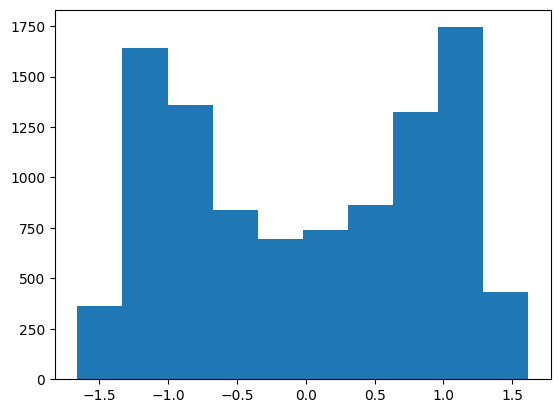

In [20]:
plt.hist(training_set.mean(axis = (1, 2, 3)))
plt.show()

## Plot

In [21]:
def init_live_plot(figsize=(8, 4), logit_scale=True, **kwargs):
    fig, ax_ess = plt.subplots(1, 1, figsize=figsize, **kwargs)

    ess_line = plt.plot([0], [0.5], color='C0', label='ESS')
    plt.grid(False)
    plt.ylabel('ESS')
    if logit_scale:
        ax_ess.set_yscale('logit')
    else:
        plt.ylim(0, 1)

    ax_loss = ax_ess.twinx()
    loss_line = plt.plot([0], [1], color='C1', label='KL Loss')
    plt.grid(False)
    plt.ylabel('Loss')
    plt.xlabel('Steps')
    plt.legend(loc='upper right')

    lines = ess_line + loss_line
    plt.legend(lines, [line.get_label() for line in lines], loc='upper center', ncol=2)

    setup = dict(
        fig=fig, ax_ess=ax_ess, ax_loss=ax_loss,
        ess_line=ess_line, loss_line=loss_line, logit=logit_scale)

    display_id = display(fig, display_id=True)
    setup['display_id'] = display_id

    return setup


def update_plots(history, setup, window_size=15):
    ess_line = setup['ess_line']
    loss_line = setup['loss_line']
    ax_loss = setup['ax_loss']
    ax_ess = setup['ax_ess']
    fig = setup['fig']

    ess = np.array(history['ess'])
    steps = np.arange(len(ess))
    ess_line[0].set_ydata(ess)
    ess_line[0].set_xdata(steps)
    if setup['logit'] and len(ess) > 1:
        ax_ess.relim()
        ax_ess.autoscale_view()

    loss = np.array(history['dkl'])
    loss_line[0].set_ydata(loss)
    loss_line[0].set_xdata(steps)
    if len(loss) > 1:
        ax_loss.relim()
        ax_loss.autoscale_view()

    setup['display_id'].update(fig)

In [22]:
metrics_history = {
    'dkl': [],
    'ess': [],
}

In [23]:
def moving_average(d, n):
    new_d = {}
    for key in d.keys():
        l = np.array(d[key])
        ma = np.cumsum(l)
        ma[n:] = (ma[n:] - ma[:-n])/n
        for i in range(min(len(ma),n)):
            ma[i] = ma[i] / (i+1)
        new_d[key] = ma
    return new_d

## Training

In [24]:
lr = optax.exponential_decay(5e-3, 8000, 1e-1)
opt = optax.adam(lr)

params = model.init(next(rns), 0, training_set[0:2])

opt_state = opt.init(params)

In [25]:
@jax.jit
def update_step(params, key, time, batch, opt_state):
    val, grads = jax.value_and_grad(jaxdf.DSM_loss, 1)(model, params, key, time, batch)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return val, params, opt_state

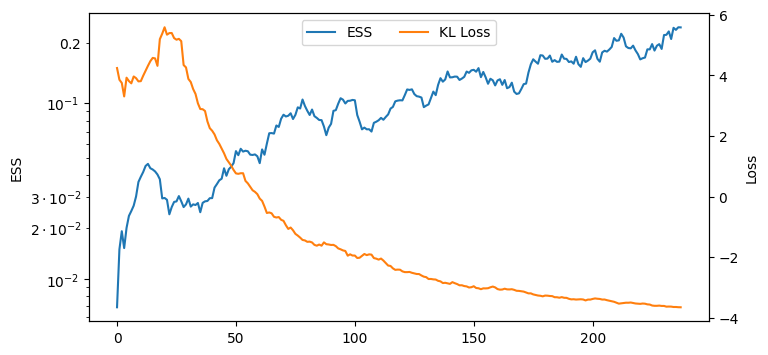

In [26]:
N_epochs = 10000
train_size = training_set.shape[0]
batch_size = 256
steps_per_epoch = 20
losses = []
eps=1e-4
plot_setup = init_live_plot()
try:
    for k in range(N_epochs):
        perms = random.permutation(next(rns), train_size)
        perms = perms[:steps_per_epoch * batch_size]
        perms = perms.reshape((steps_per_epoch, batch_size))
        time_noise = random.uniform(next(rns), (steps_per_epoch,)) / steps_per_epoch
        time_range = time_noise + jnp.arange(steps_per_epoch) / steps_per_epoch
        for perm, time in zip(perms, time_range):
            batch = training_set[perm, :]
            loss, params, opt_state = update_step(params, next(rns), time, batch, opt_state)
            losses.append(loss)
        if (k + 1) % 1 == 0:
            mean_loss = jnp.mean(jnp.array(losses))
            losses = []
            gen_set, gen_logp = model.apply(params, next(rns), 500, method=model.sample)
            gen_lattices = set_mean + gen_set * set_std
            th_logp = - theory.action(gen_lattices)
            ess = jaxdf.utils.effective_sample_size(th_logp,gen_logp)
            dkl = jaxdf.utils.reverse_dkl(th_logp, gen_logp)
            metrics_history['ess'].append(ess)
            metrics_history['dkl'].append(dkl)
            update_plots(moving_average(metrics_history,10),plot_setup)
except KeyboardInterrupt:
    plt.close()
plt.close()

In [ ]:
gen_set, gen_logp = model.apply(params,next(rns), 1000, method=model.sample)

In [ ]:
gen_lattices = (set_mean + gen_set/gen_set.std()) * set_std

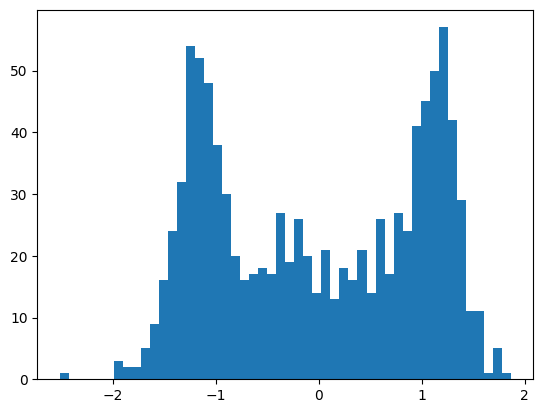

In [ ]:
plt.hist(gen_set.mean(axis=(1,2,3)), bins = 50)
plt.show()

In [ ]:
th_logp = -theory.action(gen_lattices)

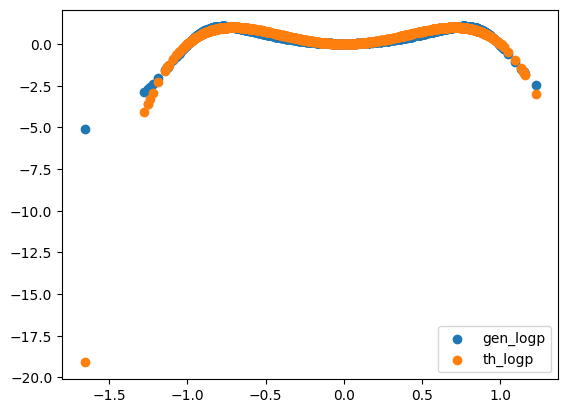

In [ ]:
fig1 = plt.scatter(gen_lattices.mean(axis=(1,2,3)),gen_logp)
fig2 = plt.scatter(gen_lattices.mean(axis=(1,2,3)),th_logp)
plt.legend((fig1,fig2),('gen_logp','th_logp'))
plt.show()

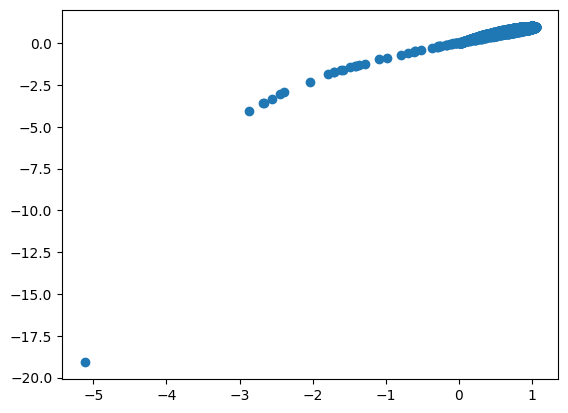

In [ ]:
plt.scatter(gen_logp,th_logp)

In [ ]:
jaxdf.utils.effective_sample_size(th_logp,gen_logp)

Array(0.9875023, dtype=float32)

In [ ]:
jaxdf.utils.reverse_dkl(th_logp,gen_logp)

Array(0.00280213, dtype=float32)

In [ ]:
ini_logp = -theory.action(lattices_set)

In [ ]:
gen_logp = gen_logp - gen_logp.mean() + ini_logp.mean()

In [ ]:
from scipy.stats import kstest
kstest(lattices_set.mean(axis=(1,2,3)), gen_lattices.mean(axis=(1,2,3)))

KstestResult(statistic=0.0254, pvalue=0.5931534503586459, statistic_location=0.9171422, statistic_sign=-1)